# Predictive modeling
## Environment Setup

In [43]:
import findspark
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler,StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.functions import vector_to_array
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, LinearSVC, GBTClassifier, FMClassifier
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
import pandas as pd

findspark.init()
spark=SparkSession.builder.master ("local[*]").appName("mini_proj_2").getOrCreate()

In [2]:
sc=spark.sparkContext

In [3]:
df=spark.read \
 .option("header","True")\
 .option("inferSchema","True")\
 .option("sep",";")\
 .csv("../data/XYZ_Bank_Deposit_Data_Classification.csv")
print("There are",df.count(),"rows",len(df.columns),
      "columns" ,"in the data.")

There are 41188 rows 21 columns in the data.


In [4]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp.var.rate: double (nullable = true)
 |-- cons.price.idx: double (nullable = true)
 |-- cons.conf.idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr.employed: double (nullable = true)
 |-- y: string (nullable = true)



## Data Preparation

In [5]:
# remove . from column names to make easier to work with
new_names = [i.replace('.', '') for i in df.columns]
df = df.toDF(*new_names)

In [6]:
# List of columns to encode
encode_list = [i[0] for i in df.dtypes if (i[1] == 'string') & (i[0] != 'y')]

In [7]:
# encode string columns
indices = {}
for column in encode_list:
    # string indexing
    indexer_fitted = StringIndexer(inputCol=column, outputCol=column + 'Index').fit(df)
    indices[column] = indexer_fitted.labels
    df = indexer_fitted.transform(df)

    # encoding
    df = OneHotEncoder(inputCol=column + 'Index', outputCol=column + 'OneHot').fit(df).transform(df)

    # cleanup
    df = df.drop(*[column, column + 'Index'])

# index y
indexer_fitted = StringIndexer(inputCol='y', outputCol='y' + 'Index').fit(df)
indices['y'] = indexer_fitted.labels
df = indexer_fitted.transform(df)
df = df.drop('y')

In [8]:
# scale numeric columns
scale_list = [i[0] for i in df.dtypes if (i[1] not in ['string', 'vector']) & (i[0] != 'yIndex')]
for i in scale_list:
    assembler = VectorAssembler(inputCols=[i],outputCol=i+"_Vect")
    scaler = StandardScaler(inputCol=i+"_Vect", outputCol=i+"_Scaled")
    pipeline = Pipeline(stages=[assembler, scaler])
    df = pipeline.fit(df).transform(df).drop(*[i, i+"_Vect"])

In [9]:
# assemble features
df = VectorAssembler(inputCols=df.drop('yIndex').columns, outputCol='features').transform(df)
features = df.select('features')

In [10]:
df_modeling = df.withColumnRenamed('yIndex', 'label').select(['features', 'label'])

## Clustering

In [11]:
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='features')
costs = {}
for k in range(2, 10):
    model = KMeans(featuresCol='features', k=k).fit(features)
    predicted = model.transform(features)
    costs[k] = evaluator.evaluate(predicted)

22/11/16 20:35:19 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


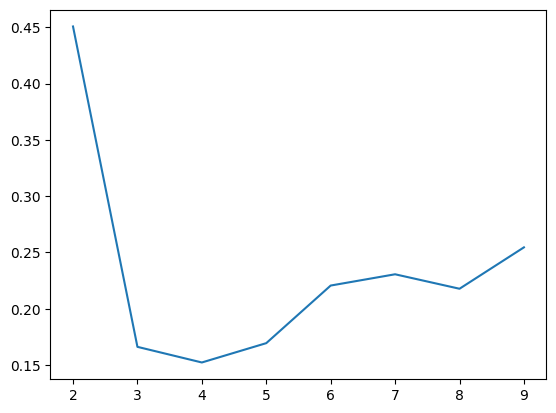

In [12]:
fig, ax = plt.subplots(1,1)
ax.plot(costs.keys(), costs.values())
plt.show()

## Classification
### Logistic Regression

In [13]:
lr = LogisticRegression()
grid = ParamGridBuilder().addGrid(lr.maxIter, [i for i in range(10)]).build()
evaluator = BinaryClassificationEvaluator()
tvs = TrainValidationSplit(estimator=lr, estimatorParamMaps=grid, evaluator=evaluator, parallelism=1, seed=42, trainRatio=.7)
tvsModel = tvs.fit(df_modeling)

In [14]:
evaluator.evaluate(tvsModel.transform(df_modeling))

0.9356395834434086

In [15]:
tvsModel.bestModel.explainParam('maxIter')

'maxIter: max number of iterations (>= 0). (default: 100, current: 5)'

In [16]:
tvsModel.bestModel.summary.areaUnderROC

0.9356394183322468

### Decision Tree

In [17]:
dt = DecisionTreeClassifier()
grid_dt = ParamGridBuilder().addGrid(dt.minInstancesPerNode, [1, 2]).addGrid(dt.impurity, ['gini', 'entropy']).build()
evaluator_dt = BinaryClassificationEvaluator()
tvs_dt = TrainValidationSplit(estimator=dt, estimatorParamMaps=grid_dt, evaluator=evaluator_dt, parallelism=1, seed=42, trainRatio=.7)
tvsModel_dt = tvs_dt.fit(df_modeling)

In [18]:
evaluator_dt.evaluate(tvsModel_dt.transform(df_modeling))

0.8743855565000961

In [19]:
tvsModel_dt.bestModel.explainParam('minInstancesPerNode')

'minInstancesPerNode: Minimum number of instances each child must have after split. If a split causes the left or right child to have fewer than minInstancesPerNode, the split will be discarded as invalid. Should be >= 1. (default: 1, current: 1)'

In [20]:
tvsModel_dt.bestModel.explainParam('impurity')

'impurity: Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini (default: gini, current: entropy)'

In [21]:
tvsModel_dt.bestModel.featureImportances

SparseVector(53, {27: 0.0014, 33: 0.0098, 34: 0.0178, 38: 0.0013, 42: 0.0005, 44: 0.526, 46: 0.0261, 47: 0.0004, 50: 0.0888, 51: 0.0008, 52: 0.3271})

### Linear SVC

In [22]:
svc = LinearSVC()
grid_svc = ParamGridBuilder().addGrid(svc.maxIter, [100]).build()
evaluator_svc = BinaryClassificationEvaluator()
tvs_svc = TrainValidationSplit(estimator=svc, estimatorParamMaps=grid_svc, evaluator=evaluator_svc, parallelism=1, seed=42, trainRatio=.7)
tvsModel_svc = tvs_svc.fit(df_modeling)

In [23]:
tvsModel_svc.bestModel.summary().areaUnderROC

0.9333733442888529

In [24]:
tvsModel_svc.bestModel.coefficients

DenseVector([0.082, -0.0063, 0.061, 0.0076, 0.0282, 0.1277, 0.0025, 0.0018, 0.0647, 0.0486, 0.1004, 0.0086, 0.0148, 0.0054, 0.0147, -0.0208, -0.0118, 0.0012, -0.0316, 0.0396, -0.0282, 0.0614, -0.0614, -0.0175, -0.0051, -0.0181, -0.0363, 0.1929, -0.274, -0.0453, 0.0305, -0.0693, -0.1882, -0.131, -0.1298, -0.1073, 0.4045, 0.0088, -0.0572, 0.0544, 0.034, -0.5493, -0.716, -0.0038, 0.4679, -0.0461, -0.1871, -0.0051, -0.2559, 0.1784, 0.0578, -0.0972, -0.0559])

### Gradient Boosted Trees

In [25]:
gbt = GBTClassifier()
grid_gbt = ParamGridBuilder().addGrid(gbt.lossType, ['logistic']).build()
evaluator_gbt = BinaryClassificationEvaluator()
tvs_gbt = TrainValidationSplit(estimator=gbt, estimatorParamMaps=grid_gbt, evaluator=evaluator_gbt, parallelism=1, seed=42, trainRatio=.7)
tvsModel_gbt = tvs_gbt.fit(df_modeling)

22/11/16 20:36:25 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/11/16 20:36:25 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


In [26]:
tvsModel_gbt.bestModel.featureImportances

SparseVector(53, {0: 0.0024, 1: 0.0039, 2: 0.0039, 3: 0.0005, 4: 0.0005, 5: 0.0013, 7: 0.0006, 8: 0.0022, 9: 0.0016, 10: 0.0024, 11: 0.0, 12: 0.0002, 13: 0.0011, 14: 0.0044, 15: 0.0013, 16: 0.0004, 18: 0.0054, 19: 0.0035, 21: 0.0103, 23: 0.0019, 24: 0.0007, 26: 0.0017, 27: 0.017, 28: 0.0079, 29: 0.0013, 32: 0.0005, 33: 0.0164, 34: 0.0071, 35: 0.0009, 36: 0.0017, 37: 0.001, 38: 0.006, 39: 0.0039, 40: 0.0088, 42: 0.0109, 43: 0.038, 44: 0.4166, 45: 0.0168, 46: 0.0381, 47: 0.0052, 48: 0.0182, 49: 0.019, 50: 0.0356, 51: 0.0891, 52: 0.1901})

In [27]:
evaluator_gbt.evaluate(tvsModel_gbt.transform(df_modeling))

0.9511376689794812

### Factorization Machines

In [28]:
fm = FMClassifier()
grid_fm = ParamGridBuilder().addGrid(fm.solver, ['adamW']).build()
evaluator_fm = BinaryClassificationEvaluator()
tvs_fm = TrainValidationSplit(estimator=fm, estimatorParamMaps=grid_fm, evaluator=evaluator_fm, parallelism=1, seed=42, trainRatio=.7)
tvsModel_fm = tvs_fm.fit(df_modeling)

In [29]:
tvsModel_fm.bestModel.summary().areaUnderROC

0.8774321522853274

## Serialize champion

In [30]:
tvsModel_gbt.save(r'../models/gbt')

Py4JJavaError: An error occurred while calling o6780.save.
: java.io.IOException: Path ../models/gbt already exists. To overwrite it, please use write.overwrite().save(path) for Scala and use write().overwrite().save(path) for Java and Python.
	at org.apache.spark.ml.util.FileSystemOverwrite.handleOverwrite(ReadWrite.scala:683)
	at org.apache.spark.ml.util.MLWriter.save(ReadWrite.scala:167)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)


## Feature Importance

In [44]:
feature_importance = pd.Series(tvsModel_gbt.bestModel.featureImportances.toArray())

In [37]:
pd_df = df.toPandas()

In [57]:
encoded_cols = [i + 'OneHot' for i in encode_list]
pd_df.loc[0,encoded_cols].map(len)

jobOneHot            11
maritalOneHot         3
educationOneHot       7
defaultOneHot         2
housingOneHot         2
loanOneHot            2
contactOneHot         1
monthOneHot           9
day_of_weekOneHot     4
poutcomeOneHot        2
Name: 0, dtype: int64

In [40]:
feature_importance.sort()

In [86]:
# top 5 important features
most_important = feature_importance.sort_values(ascending=False).reset_index().loc[:4]

In [87]:
most_important

,index,0
0,44,0.416594
1,52,0.190120
2,51,0.089148
3,46,0.038090
4,43,0.037950


In [88]:
most_important['index'] = ['duration', 'nremployed', 'euribor3m', 'pdays', 'age']
most_important.columns = ['feature', 'importance']
most_important = most_important.sort_values('importance')

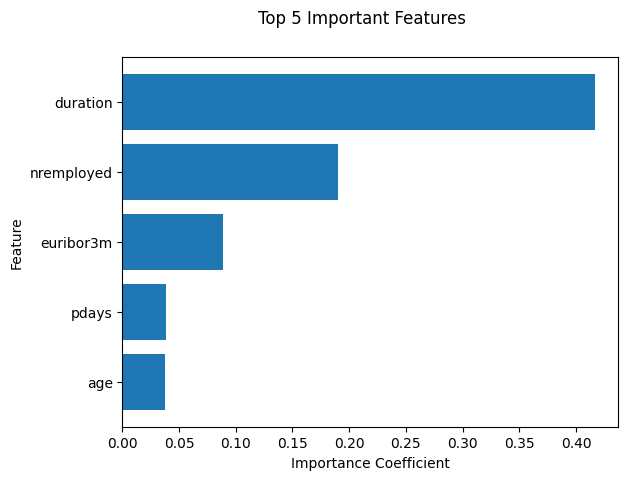

In [89]:
fig, ax = plt.subplots(1,1)
ax.barh(most_important['feature'], most_important['importance'])
fig.suptitle('Top 5 Important Features')
ax.set_ylabel('Feature')
ax.set_xlabel('Importance Coefficient')
plt.show()